In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,activations

import numpy as np

In [3]:
print(tf.__version__)

2.0.0


In [4]:
def data_processing(file_name, file_name_D):
    """
    Read the csv files and create game characterstic features and player statistic features
    """
    df = pd.read_csv(file_name)
    df_D = pd.read_csv(file_name_D)
    df.sort_values(by = ['Name', 'Unnamed: 2_level_0 G#']) # for rolling average
    # All box score player stats, except defensive statistics
    stats = ['Passing Yds','Passing Rate','Passing TD','Passing Att','Rushing Yds','FPoints']
    # Opponent Characteristics
    df, opp_features = get_opp_d(df, df_D)
    # Game Characteristic Indicators, e.g. home/away, opponent, team
#     df, game_features = get_game_char_indicators(df)
    # Player Statistic Features, e.g. Season, last 4 weeks, previous week
    df, player_features = get_player_averages(df, stats)
#     features = game_features + player_features
#     features = player_features
    df['home'] = (df['Unnamed: 6_level_0 Unnamed: 6_level_1'] == '0')*1
    features = player_features + opp_features + ['home']
    df = df.fillna(0)
    return df, features


def get_game_char_indicators(df):
    """
    Transform str cols into game categorical variables
    Returns transformed and columns
    """
    df['home'] = 1 * df['Unnamed: 6_level_0 Unnamed: 6_level_1'] == '0'
    oppts = pd.get_dummies(df['Unnamed: 7_level_0 Opp'], prefix='Oppt')
    teams = pd.DataFrame()
    team_list = pd.Series('ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET',\
                           'GB', 'HOU', 'IND', 'JAC', 'KC', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ',\
                           'OAK', 'PHI', 'PIT', 'SD', 'SEA', 'SF', 'STL', 'TB', 'TEN', 'WAS')
    for team in df['Unnamed: 5_level_0 Tm']:
        temp = (team_list == team)
        teams = teams.append(temp, ignore_index=True)
    teams.index = range(len(df['Unnamed: 5_level_0 Tm']))
    teams.columns = list(team_list)
    df = pd.concat([df, oppts, teams], axis=1)
    return df, ['home'] + list(oppts.columns) + list(team_list)

def get_opp_d(df, df_D):

    d_stats = ['Passing Cmp','Passing Att',
             'Passing Yds','Passing TD','Passing Int','Passing NY/A','Passing 1stD']
    df_D['Season']= df_D['Season'].astype(str)
#     for stat in df[d_stats + ['FPoints']]:
#         opp = abbrev_dict[df['Unnamed: 7_level_0 Opp']]
#         df['D_'+stat] = df_D.loc[df_D['Tm'] == opp][stat]
    for stat in d_stats:
#         print(stat)
        df[stat] = df.apply(lambda row: get_team_stat(row,stat,df_D), axis=1)
    return df, d_stats
def get_team_stat(row,stat,df_D):
    abbrev_dict = {'ARI':'Arizona Cardinals', 'ATL':'Atlanta Falcons', 'BAL':'Baltimore Ravens', 'BUF':'Buffalo Bills', 
                          'CAR':'Carolina Panthers', 'CHI':'Chicago Bears', 'CIN':'Cincinnati Bengals', 
                          'CLE':'Cleveland Browns', 'DAL':'Dallas Cowboys', 'DEN':'Denver Broncos', 'DET':'Detroit Lions', 
                          'GB':'Green Bay Packers','GNB':'Green Bay Packers', 'HOU': 'Houston Texans', 'IND':'Indianapolis Colts', 
                          'JAC':'Jacksonville Jaguars', 'JAX':'Jacksonville Jaguars','KAN':'Kansas City Chiefs','KC':'Kansas City Chiefs','LAC':'Los Angeles Chargers',
                          'LAR':'Los Angeles Rams', 'MIA':'Miami Dolphins', 'MIN':'Minnesota Vikings','NE':'New England Patriots','NWE':'New England Patriots',
                          'NO':'New Orleans Saints','NOR':'New Orleans Saints', 'NYG':'New York Giants', 'NYJ':'New York Jets','OAK':'Oakland Raiders', 
                          'PHI':'Philadelphia Eagles', 'PIT':'Pittsburgh Steelers', 'SD':'San Diego Chargers', 'SDG':'San Diego Chargers', 'SEA':'Seattle Seahawks', 
                          'SF':'San Francisco 49ers', 'SFO':'San Francisco 49ers','STL':'St. Louis Rams', 'TB':'Tampa Bay Buccaneers',
                           'TEN':'Tennessee Titans', 'TAM':'Tampa Bay Buccaneers',
                          'WAS':'Washington Redskins'}
#     print(row)
#     print(df_D['Season'])
    df_D.index=df_D['Tm']+df_D['Season']
#     print(df_D)
    opp = abbrev_dict[row['Unnamed: 7_level_0 Opp']]+str(row['Season'])
#     print(type(df_D.loc[df_D['Tm']==opp][stat]))
#     print(opp,stat)
    return df_D.at[opp,stat]

def rolling_average(df, window):
    return df.rolling(min_periods=1, window=window).mean().shift(1)

def get_player_averages(df, stats):
    """
    Estimate player averages for all stats and FanDuel point histories,
    for season-to-date, last 4 weeeks, and previous week
    """
    feature_names = []
    for stat in df[stats + ['FPoints']]:
        df['season_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 16))
        df['recent_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 4))
        df['prev_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 1))
        feature_names = feature_names + [time + "_" + stat for time in ['season', 'recent', 'prev']]
#         feature_names = feature_names + [time + "_" + stat for time in ['recent', 'prev']]
    return df, feature_names


path = "data/"
train, features = data_processing(path + 'QB_all.csv', path + 'teams_all.csv')
# test, features2 = data_processing(path + 'gamelog_QB_2018.csv', path + 'teams_2018.csv')
# if (features != features2):
#     print("Debug error about feature inconsistency")
#     exit()

In [5]:
train

,Unnamed: 0,Def. Snaps Num,Def. Snaps Pct,FPoints,Fumbles FF,Fumbles FR,Fumbles Fmb,Fumbles TD,Fumbles Yds,Kick Returns Rt,...,season_Passing Att,recent_Passing Att,prev_Passing Att,season_Rushing Yds,recent_Rushing Yds,prev_Rushing Yds,season_FPoints,recent_FPoints,prev_FPoints,home
0,0,0.0,0,23.52,0.0,0.0,1.0,0.0,-17.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,1
1,1,0.0,0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,...,475.000000,475.000000,475.0,-2.000000,-2.000000,-2.0,23.520000,23.520000,23.52,0
2,2,0.0,0,20.84,0.0,0.0,1.0,0.0,0.0,0.0,...,493.000000,493.000000,511.0,3.500000,3.500000,9.0,16.530000,16.530000,9.54,0
3,3,0.0,0,24.42,0.0,0.0,0.0,0.0,0.0,0.0,...,493.666667,493.666667,495.0,2.333333,2.333333,0.0,17.966667,17.966667,20.84,1
4,4,0.0,0,11.80,0.0,0.0,3.0,0.0,-17.0,0.0,...,506.500000,506.500000,545.0,1.500000,1.500000,-1.0,19.580000,19.580000,24.42,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,5876,0.0,0%,0.00,0.0,0.0,0.0,0.0,0.0,2.0,...,568.181818,582.000000,585.0,15.818182,12.750000,13.0,2.673333,1.375000,1.30,0
5877,5877,0.0,0%,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,566.000000,584.250000,542.0,14.500000,10.250000,0.0,2.673333,1.500000,0.00,0
5878,5878,0.0,0%,1.70,0.0,0.0,0.0,0.0,0.0,0.0,...,563.538462,571.750000,534.0,12.923077,2.750000,-6.0,2.673333,1.050000,0.00,0
5879,5879,0.0,0%,-2.00,0.0,0.0,0.0,0.0,0.0,0.0,...,561.071429,547.500000,529.0,13.214286,6.000000,17.0,2.576000,1.500000,1.70,1


In [6]:
features.append('FPoints')
# features.remove('home')
# features.remove('FPoints')
# print(features)
dataset = train[features]
# dataset
train_dataset = dataset.sample(frac=0.9,random_state=0)
# print(train_dataset)
test_dataset = dataset.drop(train_dataset.index)
train_stats = train_dataset.describe(include='all')
train_stats.pop('FPoints')
train_stats = train_stats.transpose()
# train_stats

In [7]:
train_labels = np.asarray(train_dataset.pop('FPoints'))
test_labels = np.asarray(test_dataset.pop('FPoints'))
train_labels

array([19.28,  0.  , 12.24, ...,  0.  , 13.38, 12.9 ])

In [8]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = np.asarray(norm(train_dataset))
normed_test_data = np.asarray(norm(test_dataset))

In [9]:
def build_model():
#     model = keras.Sequential([
#         layers.Dense(32, activation='relu', input_shape=[len(train_dataset.keys())]),
#         layers.Dense(32, activation='relu'),
#         layers.Dense(1)
#     ])


    model=keras.Sequential()
#     model.add(layers.Dense(64,input_shape=[len(train_dataset.keys())]))
    model.add(layers.Dense(8,input_shape=[len(train_dataset.keys())]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.015)
#     optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
#     optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.01, nesterov=True)

    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    return model
model = build_model()

In [10]:
example_batch = normed_train_data[:10]
example_batch

array([[ 4.41865751e-02,  1.92163633e-02, -3.15015922e-01,
        -1.06179884e-01, -1.13976690e-01, -6.42799329e-01,
         3.00228082e-01,  2.31484061e-01,  8.36793022e-01,
         3.52666862e-01,  3.34031474e-01, -7.06607787e-02,
        -1.05183039e-01, -1.00046058e-01, -5.44035222e-01,
        -5.46507703e-01, -4.85118312e-01, -1.35755834e+00,
        -5.46507703e-01, -4.85118312e-01, -1.35755834e+00,
        -1.38951345e+00, -2.51303174e-01, -1.18775430e+00,
         8.88769652e-01,  3.24908444e+00, -1.13542837e+00,
        -1.06087884e+00, -1.00577902e+00],
       [ 1.70707380e-01,  2.00659993e-01,  5.19257998e-01,
        -3.85940555e-01, -3.42851531e-01, -1.09328451e+00,
         2.16509787e-01,  6.87580937e-01,  9.87050696e-01,
         1.45935853e-01,  2.14885136e-01,  1.40833234e-02,
        -3.22470299e-01, -1.39087402e-01,  5.34997414e-01,
        -5.77067804e-01, -3.94297095e-01, -5.15825652e-01,
        -5.77067804e-01, -3.94297095e-01, -5.15825652e-01,
        -7.96

In [25]:
example_result = model.predict(example_batch)
example_result

array([[0.13477239],
       [0.0225207 ],
       [0.50677085],
       [0.3245742 ],
       [0.0459062 ],
       [0.08680809],
       [0.06881857],
       [0.03594   ],
       [0.02869542],
       [0.00874891]], dtype=float32)

In [26]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

print(normed_train_data.shape, train_labels.shape)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[PrintDot()])

(5293, 29) (5293,)

....................................................................................................
....................................................................................................

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,48.061695,5.551564,48.061699,65.415439,6.395040,65.415443,195
196,48.273956,5.557519,48.273968,66.531524,6.483286,66.531525,196
197,48.101895,5.538466,48.101891,65.238235,6.439662,65.238235,197
198,48.143047,5.555501,48.143051,67.048783,6.518729,67.048782,198
199,47.902702,5.545835,47.902695,66.027775,6.493831,66.027771,199


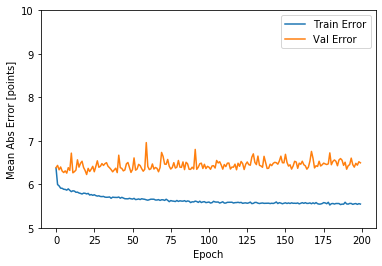

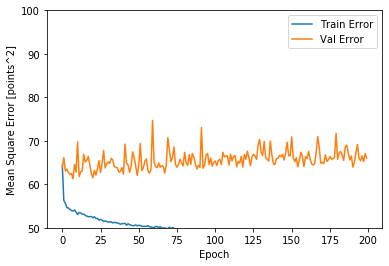

In [28]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [points]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([5,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [points^2]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([50,100])
  plt.legend()
  plt.show()
plot_history(history)


...............................

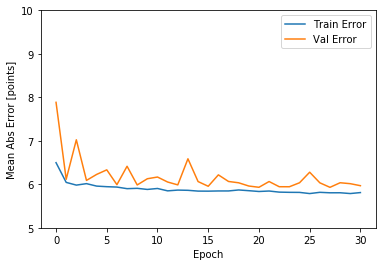

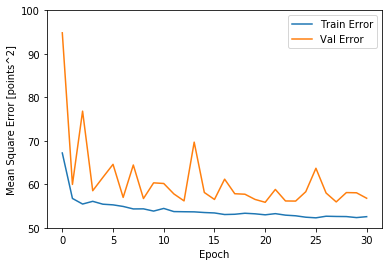

In [29]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [30]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} points".format(mae))

588/1 - 0s - loss: 62.0449 - mae: 5.5742 - mse: 49.8400
Testing set Mean Abs Error:  5.57 points


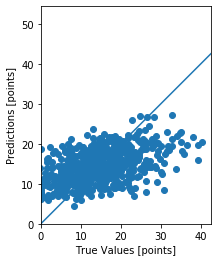

In [31]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [points]')
plt.ylabel('Predictions [points]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

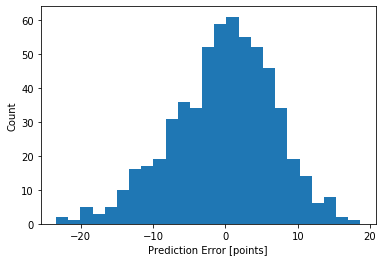

In [32]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [points]")
_ = plt.ylabel("Count")